In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import odr, sqrt
%matplotlib inline

Up to now, we've been using the Ordinary Least Squares method to find the equation of the best fit line to our data. Unfortunately, this method only takes errors in our y-values into account. In lab 1, we'll need to fit a line to data where we have uncertainties associated with both our x and y measurements.

In [4]:
def OLSfit(x, y, dy=None):
    """Find the best fitting parameters of a linear fit to the data through the 
    method of ordinary least squares estimation. (i.e. find m and b for 
    y = m*x + b)
    
    Args:
        x: Numpy array of independent variable data
        y: Numpy array of dependent variable data. Must have same size as x.
        dy: Numpy array of dependent variable standard deviations. Must be same 
            size as y.

    Returns: A list with four floating point values. [m, dm, b, db]
    """
    if dy is None:
        #if no error bars, weight every point the same
        dy = np.ones(x.size)
    denom = np.sum(1 / dy**2) * np.sum((x / dy)**2) - (np.sum(x / dy**2))**2
    m = (np.sum(1 / dy**2) * np.sum(x * y / dy**2) - 
         np.sum(x / dy**2) * np.sum(y / dy**2)) / denom
    b = (np.sum(x**2 / dy**2) * np.sum(y / dy**2) - 
         np.sum(x / dy**2) * np.sum(x * y / dy**2)) / denom
    dm = np.sqrt(np.sum(1 / dy**2) / denom)
    db = np.sqrt(np.sum(x / dy**2) / denom)
    return([m, dm, b, db])

Orthogonal Distance Regression is works to find the best fit line that minimizes the *perpendicular* distance from the data points to the line. 
![Comparison of perpendicular and vertical distance measurements, from http://blog.rtwilson.com/orthogonal-distance-regression-in-python/](http://blog.rtwilson.com/wp-content/uploads/2015/11/Normal_vs_ODR.png)
Unlike the OLS method, there's no formula that we can plug values into to get the answer. ODR finds the optimal line *numerically*. This means that it starts with some values of slope and intercept and then fiddles with them. Here's a function that implements this algorithm. You'll have to provide it with a 'guess' for the slope and uncertainty. You can generate this with an OLS fit.


In [56]:
# Use the SciPy ODR tool to fit a line to the data, I wrote a function that takes as input your x and y values,
# their uncertainties, and initial guesses for the slope and intercept of the best fit line. It returns the best fit
# slope and intercept and their uncertainties in a list with [slope,slope uncert.,intercept,intercept uncert.]

def ODRfit(x, y, dx, dy, m_init, b_init):
    linear_model = odr.Model(linearEqn)
    data = odr.RealData(x, y, sx=dx, sy=dy)
    myodr = odr.ODR(data, linear_model, beta0=[m_init, b_init])
    output = myodr.run()
    return[output.beta[0], output.sd_beta[0], 
           output.beta[1], output.sd_beta[1]]

def linearEqn(p, x):
    return p[0]*x + p[1] 

Let's try it out on some random data:

In [53]:
xs = np.abs(np.random.randint(0,20,100))
dxs = np.abs(np.random.randn(100))
ys = ((2+np.random.randn(100))*xs)+3*np.random.randn(100)
dys = 3*np.abs(np.random.randn(100))

Start with an OLS fit, which will only take the y uncertainties into account, but will provide an initial value of slope and intercept for the algorithm.

In [57]:
olsfit = OLSfit(xs, ys, dy=dys)
print('Slope=',olsfit[0],'+/-',olsfit[1])
print('Intercept=',olsfit[2],'+/-',olsfit[3])

('Slope=', 1.6449485432374951, '+/-', 0.0029388038343843453)
('Intercept=', 5.2847513412531102, '+/-', 0.011395242763823692)


Now we can use the ODR fit function with the slope an intercept values found by the OLS fit.

In [58]:
odrfit = ODRfit(xs,ys,dxs,dys,olsfit[0],olsfit[2])
print('Slope=',odrfit[0],'+/-',odrfit[1])
print('Intercept=',odrfit[2],'+/-',odrfit[3])

('Slope=', 2.4852643422524223, '+/-', 0.18446742137743272)
('Intercept=', -3.0329852349563051, '+/-', 1.9339228436053264)


Let's make a plot and compare the two lines.

(-2, 25)

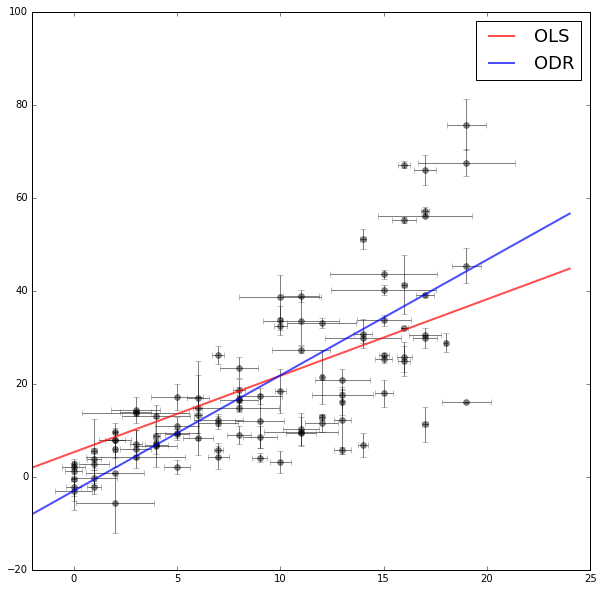

In [62]:
plt.errorbar(xs,ys,xerr=dxs,yerr=dys,fmt='o',color='black',alpha=0.5)
plt.plot(np.arange(-2,25,1),olsfit[0]*np.arange(-2,25,1)+olsfit[2],color='red',lw=2,alpha=0.7,label='OLS')
plt.plot(np.arange(-2,25,1),odrfit[0]*np.arange(-2,25,1)+odrfit[2],color='blue',lw=2,alpha=0.7,label='ODR')
plt.gcf().set_size_inches(10,10)
plt.legend(fontsize=18)
plt.xlim(-2,25)